# IEKF class example

In [12]:
import sympy as sp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cw.filters import IteratedExtendedKalmanFilter

In [6]:
x1, x2, u1 = sp.symbols("x1 x2 u1")
iekf = IteratedExtendedKalmanFilter(
    x=[x1, x2],
    z=['z1'],
    u=[u1],
    f=sp.Matrix([
        x2*sp.cos(x1)**3 + u1,
        x2 * u1 - x2
    ]),
    h=sp.Matrix([
        x1**2 + x2**2 * u1
    ]),
    g=sp.Matrix(np.eye(2)),
    max_iterations=100,
    eps=1e-10,
)
print(iekf)

ExtendedKalmanFilter:
  x:
    (x₁, x₂)
  z:
    (z1,)
  u:
    (u₁,)
  f:
    ⎡           3    ⎤
    ⎢u₁ + x₂⋅cos (x₁)⎥
    ⎢                ⎥
    ⎣   u₁⋅x₂ - x₂   ⎦
  g:
    ⎡1.0  0.0⎤
    ⎢        ⎥
    ⎣0.0  1.0⎦
  h:
    ⎡     2     2⎤
    ⎣u₁⋅x₂  + x₁ ⎦
  fx:
    ⎡                 2         3    ⎤
    ⎢-3⋅x₂⋅sin(x₁)⋅cos (x₁)  cos (x₁)⎥
    ⎢                                ⎥
    ⎣          0              u₁ - 1 ⎦
  hx:
    [2⋅x₁  2⋅u₁⋅x₂]



In [9]:
# Create input signal.
t = np.arange(0, 10, 0.01)
u1_values = 3 * np.sin(2*np.pi*t)
u = xr.Dataset(
    data_vars={
        "u1": (('t',), u1_values)
    },
    coords={"t": t}
)

# Generate test data by simulating dynamics
np.random.seed(0)
data = iekf.sim(
    x_0=[2, -3],
    u=u,
    system_noise=[1., 1.],
    system_bias=[0., 0.],
    measurement_noise=[1.],
    measurement_bias=[0.],
)

In [10]:
data

<xarray.Dataset>
Dimensions:  (t: 1000)
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 9.95 9.96 9.97 9.98 9.99
Data variables:
    u1       (t) float64 0.0 0.1884 0.376 0.5621 ... -0.5621 -0.376 -0.1884
    x1       (t) float64 2.0 2.012 2.026 2.033 2.046 ... 3.692 3.687 3.668 3.669
    x2       (t) float64 -3.0 -2.948 -2.925 -2.892 ... -0.1188 -0.1112 -0.1147
    z1       (t) float64 5.764 7.552 7.217 9.598 ... 15.57 13.69 13.51 15.24

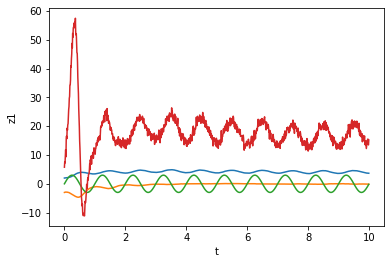

In [13]:
plt.figure()
data.x1.plot()
data.x2.plot()
data.u1.plot()
data.z1.plot()

In [14]:
filtered_data = iekf.filter(
    data=data,
    x_0=[10, 1],
    p_0=np.diag([100., 100.]),
    q=np.eye(2),
    r=[[1.]]
)

In [15]:
filtered_data

<xarray.Dataset>
Dimensions:       (dim_0: 2, dim_1: 2, t: 1000)
Coordinates:
  * t             (t) float64 0.0 0.01 0.02 0.03 0.04 ... 9.96 9.97 9.98 9.99
Dimensions without coordinates: dim_0, dim_1
Data variables:
    u1            (t) float64 0.0 0.1884 0.376 0.5621 ... -0.5621 -0.376 -0.1884
    x1            (t) float64 2.0 2.012 2.026 2.033 ... 3.692 3.687 3.668 3.669
    x2            (t) float64 -3.0 -2.948 -2.925 ... -0.1188 -0.1112 -0.1147
    z1            (t) float64 5.764 7.552 7.217 9.598 ... 13.69 13.51 15.24
    x1_est        (t) float64 10.0 2.404 2.397 2.438 ... 3.691 3.702 3.697 3.692
    x2_est        (t) float64 1.0 1.021 3.079 ... -0.003001 -0.00298 -0.002817
    p_k1k1        (t, dim_0, dim_1) float64 100.0 0.0 ... -0.0001297 0.002501
    iekf_i_count  (t) int64 0 9 8 18 9 9 16 12 7 8 7 7 ... 4 4 5 5 4 4 5 4 5 3 3

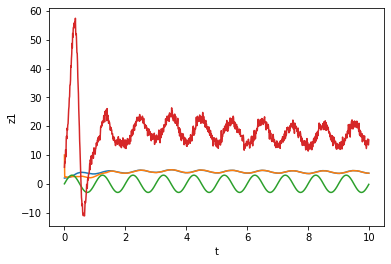

In [19]:
plt.figure()
filtered_data.x1.plot()
filtered_data.x1_est.plot()
filtered_data.u1.plot()
filtered_data.z1.plot()